In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
from simuq.systems.ising import GenQS
from simuq.providers import BraketProvider

In [3]:
N = 6
T = 1
scale_T = 3.5
scaler = scale_T / T
qs = GenQS(N, scale_T, 1 / scaler, 1 / scaler, is_chain=False)

In [4]:
awsp = BraketProvider()

In [5]:
awsp.compile(qs, 'quera', 'Aquila', 'rydberg2d_global', tol=1)

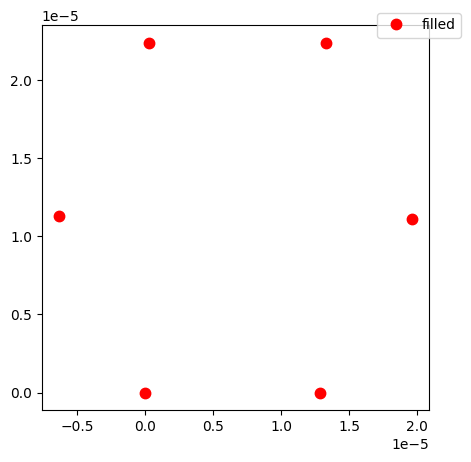

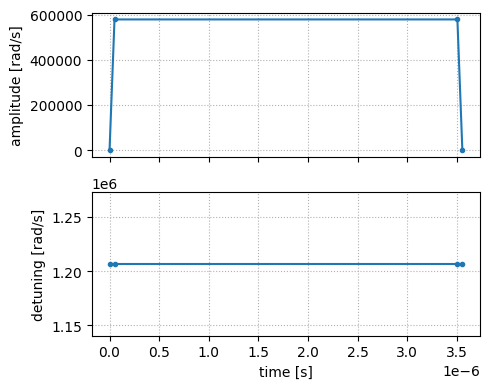

In [7]:
awsp.visualize()

In [8]:
awsp.run(shots=1000000, on_simulator = True)

Submitted.


In [24]:
res = awsp.results()

In [25]:
import numpy as np
from numpy import kron, matmul
from scipy.linalg import norm, expm

def list_kron(l) :
    ret = np.array([[1]])
    for i in range(len(l)) :
        ret = kron(ret, l[i])
    return ret

def calc_prob(is_chain, N, T) :
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])
    zero = np.array([[1], [0]])
    H_ising = np.zeros((1<<N, 1<<N))
    for i in range(N - 1 if is_chain else N) :
        l = [I for j in range(N)]
        l[i] = Z
        l[(i + 1) % N] = Z
        H_ising = H_ising + list_kron(l)
    for i in range(N) :
        l = [I for j in range(N)]
        l[i] = X
        H_ising = H_ising + list_kron(l)
    
    l = [zero for j in range(N)]
    init = list_kron(l)
    
    final = matmul(expm(-1j * T * H_ising), init)
    prob = [np.abs(final[i][0]) ** 2 for i in range(1<<N)]
    return prob

ideal_prob = calc_prob(False, N, T)
print(ideal_prob)
#ideal_prob = [0.3021633811822922, 0.0220103604525164, 0.02201036045251638, 0.026829759768424156, 0.022010360452516364, 0.0015171690483644104, 0.026829759768424118, 0.02694282896481442, 0.022010360452516472, 0.0027571786028360704, 0.0015171690483644, 0.0005236879121431605, 0.026829759768424173, 0.0005236879121431581, 0.026942828964814383, 0.022587808945176462, 0.022010360452516423, 0.0015171690483644022, 0.002757178602836066, 0.0005236879121431634, 0.0015171690483643963, 0.00023958383685457026, 0.0005236879121431612, 1.2745865712279464e-05, 0.026829759768424256, 0.0005236879121431598, 0.0005236879121431602, 0.0032596618172474104, 0.026942828964814394, 1.274586571227973e-05, 0.022587808945176428, 0.00788584927053793, 0.02201036045251644, 0.026829759768424145, 0.0015171690483644022, 0.026942828964814338, 0.0027571786028360618, 0.0005236879121431592, 0.0005236879121431628, 0.022587808945176452, 0.0015171690483644033, 0.0005236879121431621, 0.0002395838368545729, 1.2745865712279928e-05, 0.0005236879121431622, 0.003259661817247407, 1.2745865712279902e-05, 0.007885849270537915, 0.026829759768424208, 0.0269428289648144, 0.0005236879121431595, 0.02258780894517647, 0.0005236879121431607, 1.2745865712279931e-05, 0.0032596618172474104, 0.007885849270537915, 0.026942828964814383, 0.022587808945176487, 1.2745865712280006e-05, 0.00788584927053791, 0.02258780894517651, 0.007885849270537915, 0.007885849270537922, 0.026303541044756046]

[0.3021633811822922, 0.0220103604525164, 0.02201036045251638, 0.026829759768424156, 0.022010360452516364, 0.0015171690483644104, 0.026829759768424118, 0.02694282896481442, 0.022010360452516472, 0.0027571786028360704, 0.0015171690483644, 0.0005236879121431605, 0.026829759768424173, 0.0005236879121431581, 0.026942828964814383, 0.022587808945176462, 0.022010360452516423, 0.0015171690483644022, 0.002757178602836066, 0.0005236879121431634, 0.0015171690483643963, 0.00023958383685457026, 0.0005236879121431612, 1.2745865712279464e-05, 0.026829759768424256, 0.0005236879121431598, 0.0005236879121431602, 0.0032596618172474104, 0.026942828964814394, 1.274586571227973e-05, 0.022587808945176428, 0.00788584927053793, 0.02201036045251644, 0.026829759768424145, 0.0015171690483644022, 0.026942828964814338, 0.0027571786028360618, 0.0005236879121431592, 0.0005236879121431628, 0.022587808945176452, 0.0015171690483644033, 0.0005236879121431621, 0.0002395838368545729, 1.2745865712279928e-05, 0.00052368791214

In [26]:
def flaten_prob(pd) :
    N = len(list(pd.keys())[0])
    prob = [0 for i in range(1<<N)]
    for i in pd.keys() :
        prob[int(i, 2)] = pd[i]
    return prob

def calc_dist(prob1, prob2):
    sum_error = 0
    for i in range(len(prob1)) :
        sum_error += abs(prob1[i] - prob2[i])
    return sum_error / 2

In [27]:
print(calc_dist(ideal_prob, flaten_prob(res)))

0.04498791808714185


In [28]:
res = awsp.results(task_arn = "arn:aws:braket:us-east-1:795824654075:quantum-task/acd3ae81-a220-41a7-ac34-d3f6371cb516")

In [29]:
print(calc_dist(ideal_prob, flaten_prob(res)))

0.48794713095777265
